<a href="https://colab.research.google.com/github/patimus-prime/ML_notebooks/blob/master/SMILES_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A less noisy version of another notebook, and with more up to date code. The other is on my Github in the same folder as this on. Objective is the same, predict protein classification of the target of a plethora of small molecules given only their SMILES code.

Additionally, I'll be using the Mordred library. I'm also using chatGPT as a partner in development, and cite it however later, and link the conversation so maybe future me or others can see how it can be best queried.

In [1]:
# from multiprocessing import cpu_count
# cpu_count() # 2 with GPU runtime on Colab. And with plain CPU runtime. RIP

2

NOTE: Runtime -> Change runtime type -> GPU

In [2]:
# Next few cells get all libraies/mount google drive for data
# THE KERNEL/COLAB SESSION WILL BE RESTARTED/report crash. NORMAL
# THEN RE-RUN THIS CELL, IDK WHAT IT IS WITH CONDACOLAB IT'S ANNOYING

!pip install -q condacolab # for getting conda packages
# !pip install -q colabcode #opens a default VSCode on web, optional if additional scripts; else Colab is fine.
# !pip install --quiet pytorch-lightning datetime # will install torch automatically

import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


Mount drive, acquire data; the dataset I'm loading is a fraction of the complete set; complete generation will require colab pro etc. for a longer runtime before timeout.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# *****AFTER THIS YOU SHOULD BE ABLE TO JUST RUNTIME -> RUN EVERYTHING AFTER THIS CELL!!!!!!*****

Next cell confirms proper install of condacolab, on sucessful install returns cake.

In [5]:
condacolab.check() # should see cake

✨🍰✨ Everything looks OK!


In [6]:
# AFTER RESTART, RUN THIS CELL TO BE SURE A-OK. THEN RUN ALL AGAIN.
import condacolab # this here just out of paranoia
# now get rdkit
!mamba install -q -c conda-forge rdkit
# and mordred, in this later version. not sure if it also scoops up rdkit by default
!mamba install -c conda-forge mordred

# -q for quiet-ish installation, cleaner cell; this should take about 2 mins to run and scoop up rdkit


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.0.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

  Package                        Version  Build                Channel                   Size
────────────────────

In [7]:
# check we have mordred
!python -c "import mordred"

# GUCCI GUCCI!

In [8]:
# list file system so we can double check, inform file call below
!ls

condacolab_install.log	drive  sample_data


So pretty quick we'll likely deviate from OG code. Mordred includes all the RDKit descriptors yo.
https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y
h

In [9]:
# Let's get data loaded in. Probably only use approx. 5-10% for development, given Mordred will take some time
import pandas as pd
complete_df = pd.read_csv("drive/MyDrive/0_ML/SMILES/smiles_l1.csv")  # warning: BIG file

# 10% timeout, therefore we'll need to run this notebook on EC2 to get
# the data when all is said and done
# starting with 1%
df = complete_df.sample(frac=0.10, replace=False, random_state=42)

# alternative if desired to train the model on EVERYTHING:
# df = complete_df

df.dropna() #paranoia

# get those lists in the 2nd column resolved; unknown to me still if they're just dup'd
# using ast.literal_eval enables import as a list w one element rather than an entire list
import ast
df.L1_class_name = df.L1_class_name.apply(ast.literal_eval)


In [10]:
df.head()

,canonical_smiles,L1_class_name
335893,CCN1CCN(Cc2cc(Br)cc(OC)c2O)CC1,[Enzyme]
549562,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2cc(F)c3...,[Unclassified protein]
107519,CC(C)(Cc1ccccc1)/[N+]([O-])=C\c1ccc(C(F)(F)F)cc1,[Epigenetic regulator]
258417,CCCCCCOc1ccc2ccn(CC[C@H](CO)n3cnc(C(N)=O)c3)c2c1,[Enzyme]
1157773,N[C@@H](Cc1ccccc1)C(=O)N1CCCC1P(=O)(Oc1ccccc1)...,[Enzyme]


In [11]:
df.describe() # wanna see how many samples we got with whatever x% working with

,canonical_smiles,L1_class_name
count,143789,143789
unique,143789,19
top,CCN1CCN(Cc2cc(Br)cc(OC)c2O)CC1,[Enzyme]
freq,1,70174


Further processing for this L1_class_name

In [12]:
df['stringL1'] = df['L1_class_name'].apply(lambda x: x[0])
df.head()
# so this lambda fn; we set x = the first and only element in L1_class_name; that
# x becomes new L1 feature in our new column. 

,canonical_smiles,L1_class_name,stringL1
335893,CCN1CCN(Cc2cc(Br)cc(OC)c2O)CC1,[Enzyme],Enzyme
549562,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2cc(F)c3...,[Unclassified protein],Unclassified protein
107519,CC(C)(Cc1ccccc1)/[N+]([O-])=C\c1ccc(C(F)(F)F)cc1,[Epigenetic regulator],Epigenetic regulator
258417,CCCCCCOc1ccc2ccn(CC[C@H](CO)n3cnc(C(N)=O)c3)c2c1,[Enzyme],Enzyme
1157773,N[C@@H](Cc1ccccc1)C(=O)N1CCCC1P(=O)(Oc1ccccc1)...,[Enzyme],Enzyme


We'll reorganize this later... I think. This will create the target class we'll have at the END of the dataframe... unless mordred gives a good method to deal with stuff at the end. 

## For now, we now define the features we'll be generating for these SMILES codes

A list here: https://mordred-descriptor.github.io/documentation/master/descriptors.html

In [13]:
from mordred import descriptors

# advise, during optimization, going through with
# descriptors.feature.SPECIFICfeatures

desc_list = [
    descriptors.Weight,  # Molecular weight
    descriptors.TopoPSA,  # Topological polar surface area
    descriptors.RotatableBond,  # Rotatable bond count
    descriptors.Aromatic,  # Aromatic atom count
    descriptors.HydrogenBond,  # Hydrogen bond acceptor count
    descriptors.SLogP,  # LogP
    descriptors.AcidBase,  # Solubility
    descriptors.CPSA.RASA,  # Hydrophobicity... many measures if we're not careful
    descriptors.Polarizability,  # Molecular polarizability
    descriptors.McGowanVolume,  # McGowan volume
    # descriptors.ABCIndex, # atom-bond-connectivity index, probs similar to below indeces
    descriptors.BalabanJ,  # Balaban's J index
    descriptors.BertzCT,  # Bertz CT index
]


That's our setup features. We'll now setup and declare for feature generation.

In [14]:
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(desc_list, ignore_3D=True) # True is not preferable. But enforces faster

# convert SMILES to RDKit molecules
mols = [Chem.MolFromSmiles(smiles) for smiles in df['canonical_smiles']]

# calculate descriptors for all molecules
# advisable to keep in separate df at first cuz mordred can get wonky with
desc_df = calc.pandas(mols) # this uses mordred's pandas method, do not use pandas itself or pain.

# a minute and a half for 1% of data. So 150 minutes, 2.5 hours for ALL data to be generated 

100%|██████████| 143789/143789 [20:36<00:00, 116.24it/s]


In [15]:
desc_df.insert(loc = 0,
               column = 'canonical_smiles',
               value = list(df.canonical_smiles) # this took mucho pain to finally get working lol
               )
desc_df.insert(loc = len(desc_df.columns), # NOTE: -1 does not work :[
               column = 'stringL1',
               value = list(df.stringL1)
               )

desc_df.head()

,canonical_smiles,MW,AMW,TopoPSA(NO),TopoPSA,nRot,RotRatio,nAromAtom,nAromBond,nHBAcc,...,SLogP,SMR,nAcid,nBase,apol,bpol,VMcGowan,BalabanJ,BertzCT,stringL1
0,CCN1CCN(Cc2cc(Br)cc(OC)c2O)CC1,328.078640,8.201966,35.94,35.94,4,0.2,6,6,4,...,2.3008,79.7498,0,2,44.236653,27.603347,222.70,1.838066,431.699295,Enzyme
1,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2cc(F)c3...,969.454888,7.400419,198.03,198.03,11,0.1375,31,32,11,...,8.9686,261.8248,0,0,145.390580,81.411420,710.17,0.813887,3031.979723,Unclassified protein
2,CC(C)(Cc1ccccc1)/[N+]([O-])=C\c1ccc(C(F)(F)F)cc1,321.134049,7.832538,26.07,26.07,4,0.166667,12,12,1,...,4.6559,84.4624,0,0,45.635274,22.834726,233.79,1.777192,673.662928,Epigenetic regulator
3,CCCCCCOc1ccc2ccn(CC[C@H](CO)n3cnc(C(N)=O)c3)c2c1,398.231791,6.749691,95.30,95.30,12,0.387097,14,15,6,...,3.5195,113.0597,0,0,63.549790,36.690210,315.69,1.410181,931.185073,Enzyme
4,N[C@@H](Cc1ccccc1)C(=O)N1CCCC1P(=O)(Oc1ccccc1)...,450.170844,7.630014,81.86,91.67,8,0.228571,18,18,5,...,4.8560,124.6029,0,1,68.791411,41.274589,340.57,1.443667,1017.574496,Enzyme


 Above cells will take quite some time to run. Therefore whenever it's done, we export to csv, save progress in case I walk away.

In [16]:
desc_df.to_csv("drive/MyDrive/0_ML/SMILES/smiles_mordred_10_rand42.csv", sep='\t',encoding='utf-8')

alternative if now loading from  this point!

In [ ]:
import pandas as pd
complete_df = pd.read_csv("drive/MyDrive/0_ML/SMILES/smiles_mordred_10_rand42.csv") 

---

# WE NOW ONE-HOT ENCODE, VISUALIZE AND PREP FOR ML!!

In [17]:
# for simplicity going forward
df = desc_df

In [18]:
df.describe()

,MW,AMW,TopoPSA(NO),TopoPSA,nRot,nAromAtom,nAromBond,nHBAcc,nHBDon,SLogP,SMR,nAcid,nBase,apol,bpol,VMcGowan,BalabanJ,BertzCT
count,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000
mean,434.114657,8.020237,94.514448,103.228893,6.545285,14.161042,14.559250,5.628657,2.010689,3.316325,116.170442,0.202067,0.505901,62.920414,33.732231,317.313082,1.431061,1056.779545
std,262.358534,1.208496,110.481055,115.856140,8.221167,6.388743,6.690019,4.240625,3.901811,2.305250,66.608681,0.606240,1.203991,38.704593,23.289589,196.524217,0.491758,730.794040
min,17.026549,4.256637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-65.884100,0.000000,0.000000,0.000000,1.604000,0.000000,18.300000,-0.000014,0.000000
25%,331.204848,7.242415,57.950000,63.910000,4.000000,11.000000,11.000000,4.000000,1.000000,2.358200,89.528200,0.000000,0.000000,47.631481,24.023898,241.940000,1.244804,738.224249
50%,398.110294,7.859926,78.260000,86.480000,5.000000,14.000000,15.000000,5.000000,1.000000,3.426600,107.026800,0.000000,0.000000,57.308274,30.348554,288.800000,1.425743,969.424015
75%,473.154663,8.608816,102.440000,113.300000,7.000000,18.000000,18.000000,7.000000,2.000000,4.517900,127.132400,0.000000,1.000000,68.589653,37.690245,343.580000,1.633496,1223.470303
max,7749.959555,74.947121,3322.210000,4010.610000,278.000000,168.000000,180.000000,205.000000,86.000000,22.673300,1779.682100,22.000000,31.000000,1265.152570,704.907430,5719.230000,7.508972,28240.184562


In [19]:
df.dropna()
df.describe()

,MW,AMW,TopoPSA(NO),TopoPSA,nRot,nAromAtom,nAromBond,nHBAcc,nHBDon,SLogP,SMR,nAcid,nBase,apol,bpol,VMcGowan,BalabanJ,BertzCT
count,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000,143789.000000
mean,434.114657,8.020237,94.514448,103.228893,6.545285,14.161042,14.559250,5.628657,2.010689,3.316325,116.170442,0.202067,0.505901,62.920414,33.732231,317.313082,1.431061,1056.779545
std,262.358534,1.208496,110.481055,115.856140,8.221167,6.388743,6.690019,4.240625,3.901811,2.305250,66.608681,0.606240,1.203991,38.704593,23.289589,196.524217,0.491758,730.794040
min,17.026549,4.256637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-65.884100,0.000000,0.000000,0.000000,1.604000,0.000000,18.300000,-0.000014,0.000000
25%,331.204848,7.242415,57.950000,63.910000,4.000000,11.000000,11.000000,4.000000,1.000000,2.358200,89.528200,0.000000,0.000000,47.631481,24.023898,241.940000,1.244804,738.224249
50%,398.110294,7.859926,78.260000,86.480000,5.000000,14.000000,15.000000,5.000000,1.000000,3.426600,107.026800,0.000000,0.000000,57.308274,30.348554,288.800000,1.425743,969.424015
75%,473.154663,8.608816,102.440000,113.300000,7.000000,18.000000,18.000000,7.000000,2.000000,4.517900,127.132400,0.000000,1.000000,68.589653,37.690245,343.580000,1.633496,1223.470303
max,7749.959555,74.947121,3322.210000,4010.610000,278.000000,168.000000,180.000000,205.000000,86.000000,22.673300,1779.682100,22.000000,31.000000,1265.152570,704.907430,5719.230000,7.508972,28240.184562


In [20]:
# not losing any count above, that's v. gucci, no errors so far.
df.dtypes

canonical_smiles     object
MW                  float64
AMW                 float64
TopoPSA(NO)         float64
TopoPSA             float64
nRot                  int64
RotRatio             object
nAromAtom             int64
nAromBond             int64
nHBAcc                int64
nHBDon                int64
SLogP               float64
SMR                 float64
nAcid                 int64
nBase                 int64
apol                float64
bpol                float64
VMcGowan            float64
BalabanJ            float64
BertzCT             float64
stringL1             object
dtype: object

In [21]:
# Generate one-hot-encoded stringL1 feature
df['Target_Class'], uniques = pd.factorize(df.stringL1)
df.head()

,canonical_smiles,MW,AMW,TopoPSA(NO),TopoPSA,nRot,RotRatio,nAromAtom,nAromBond,nHBAcc,...,SMR,nAcid,nBase,apol,bpol,VMcGowan,BalabanJ,BertzCT,stringL1,Target_Class
0,CCN1CCN(Cc2cc(Br)cc(OC)c2O)CC1,328.078640,8.201966,35.94,35.94,4,0.2,6,6,4,...,79.7498,0,2,44.236653,27.603347,222.70,1.838066,431.699295,Enzyme,0
1,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2cc(F)c3...,969.454888,7.400419,198.03,198.03,11,0.1375,31,32,11,...,261.8248,0,0,145.390580,81.411420,710.17,0.813887,3031.979723,Unclassified protein,1
2,CC(C)(Cc1ccccc1)/[N+]([O-])=C\c1ccc(C(F)(F)F)cc1,321.134049,7.832538,26.07,26.07,4,0.166667,12,12,1,...,84.4624,0,0,45.635274,22.834726,233.79,1.777192,673.662928,Epigenetic regulator,2
3,CCCCCCOc1ccc2ccn(CC[C@H](CO)n3cnc(C(N)=O)c3)c2c1,398.231791,6.749691,95.30,95.30,12,0.387097,14,15,6,...,113.0597,0,0,63.549790,36.690210,315.69,1.410181,931.185073,Enzyme,0
4,N[C@@H](Cc1ccccc1)C(=O)N1CCCC1P(=O)(Oc1ccccc1)...,450.170844,7.630014,81.86,91.67,8,0.228571,18,18,5,...,124.6029,0,1,68.791411,41.274589,340.57,1.443667,1017.574496,Enzyme,0


Index(['Enzyme', 'Unclassified protein', 'Epigenetic regulator',
       'Membrane receptor', 'Transporter', 'Transcription factor',
       'Ion channel', 'Other membrane protein', 'Other cytosolic protein',
       'Secreted protein', 'Structural protein', 'Other nuclear protein',
       'Surface antigen', 'Adhesion', 'Auxiliary transport protein'],
      dtype='object')

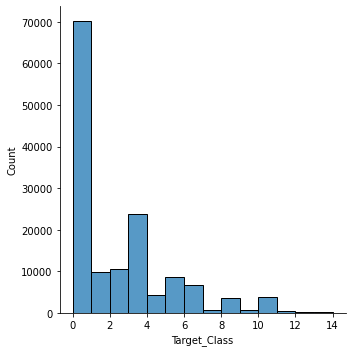

In [22]:
# View distribution of classes -- in this dataset should always be poor balance and thus we
# correct below
import matplotlib.pyplot as plt
import seaborn as sns
sns.displot(df, x='Target_Class',bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

# if just loading generated table, this will throw errors
uniques

In [23]:
"""
# an extra couple graphs if you want later
sns.relplot(x='TPSA',y='LASA',hue="string_L1", palette="bright",data=df)

for i in range(len(features)):
    plt.figure(figsize=(12,6)) # only affects next produced plot, i think
    sns.violinplot(x="Target_Class", y = features[i], data=df)
    plt.show()
"""

'\n# an extra couple graphs if you want later\nsns.relplot(x=\'TPSA\',y=\'LASA\',hue="string_L1", palette="bright",data=df)\n\nfor i in range(len(features)):\n    plt.figure(figsize=(12,6)) # only affects next produced plot, i think\n    sns.violinplot(x="Target_Class", y = features[i], data=df)\n    plt.show()\n'

<ipython-input-24-adea8b6ae34b>:2: FutureWarning: The default value of numeric_only in MordredDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


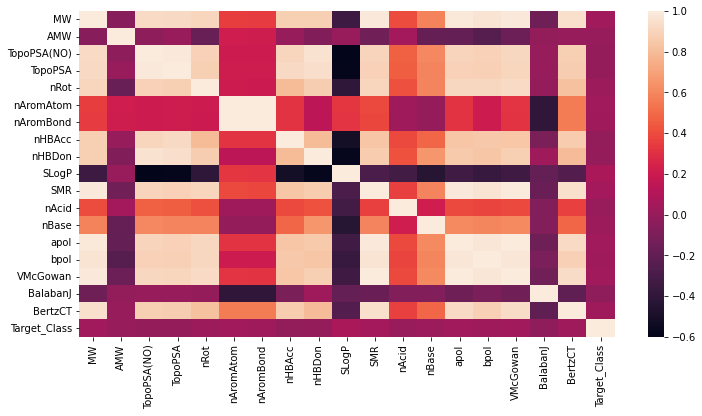

In [24]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr())

A good bit of correlation. We'll want to therefore include more features later from Mordred, will take a look at other approaches etc. 

This next chunk I got a lot from telling ChatGPT the pipeline I wanted and what I wanted it to do. Let's see how it does. Pretty dope it at least looks correct. UPDATE: It was not.

In [25]:
# DANGEROUS CODE, SO MUCH WORK TO GO BACK AND FORTH WITH FEATURES

# import numpy as np
# df = np.nan_to_num(df) # if there are somehow any na left, convert to some num

# np.nan_to_num(df) # if there are somehow any na left, convert to some num
# df = pd.DataFrame(df, columns=['col1', 'col2', 'col3'])

# # check for NaN values in the input data
# print(df.isna().sum())

# # check for infinite values in the input data
# print(np.isfinite(df).sum())

In [28]:
# try to replace any weird things
import numpy as np

df.replace([np.inf, -np.inf], np.nan, inplace=True) 
df.dropna() # then drop na

,canonical_smiles,MW,AMW,TopoPSA(NO),TopoPSA,nRot,RotRatio,nAromAtom,nAromBond,nHBAcc,...,SMR,nAcid,nBase,apol,bpol,VMcGowan,BalabanJ,BertzCT,stringL1,Target_Class
0,CCN1CCN(Cc2cc(Br)cc(OC)c2O)CC1,328.078640,8.201966,35.94,35.94,4,0.2,6,6,4,...,79.7498,0,2,44.236653,27.603347,222.70,1.838066,431.699295,Enzyme,0
1,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2cc(F)c3...,969.454888,7.400419,198.03,198.03,11,0.1375,31,32,11,...,261.8248,0,0,145.390580,81.411420,710.17,0.813887,3031.979723,Unclassified protein,1
2,CC(C)(Cc1ccccc1)/[N+]([O-])=C\c1ccc(C(F)(F)F)cc1,321.134049,7.832538,26.07,26.07,4,0.166667,12,12,1,...,84.4624,0,0,45.635274,22.834726,233.79,1.777192,673.662928,Epigenetic regulator,2
3,CCCCCCOc1ccc2ccn(CC[C@H](CO)n3cnc(C(N)=O)c3)c2c1,398.231791,6.749691,95.30,95.30,12,0.387097,14,15,6,...,113.0597,0,0,63.549790,36.690210,315.69,1.410181,931.185073,Enzyme,0
4,N[C@@H](Cc1ccccc1)C(=O)N1CCCC1P(=O)(Oc1ccccc1)...,450.170844,7.630014,81.86,91.67,8,0.228571,18,18,5,...,124.6029,0,1,68.791411,41.274589,340.57,1.443667,1017.574496,Enzyme,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143784,COc1cc(OC)cc(N(C[C@@H](O)C(F)(F)F)c2ccc3ncc(-c...,516.209673,8.065776,111.55,111.55,10,0.25,21,22,9,...,133.0442,0,1,70.430411,39.027589,359.44,1.431331,1339.007410,Enzyme,0
143785,CC(=O)N[C@@H](CS)C(=O)N[C@@H](CCC(N)=O)C(=O)N[...,1760.718780,7.722451,707.91,785.51,52,0.403101,30,32,23,...,453.3616,1,3,248.118472,132.287528,1292.44,1.265811,4820.998390,Unclassified protein,1
143786,COc1ccc(CNC(C)=O)cc1-n1nc2c(c1C(C)C)C(c1ccc(Cl...,607.175310,8.317470,98.46,98.46,7,0.152174,23,23,7,...,163.2602,0,0,85.508583,42.159417,435.31,1.473303,1766.541360,Other nuclear protein,11
143787,O=C(c1ccco1)N1CCN(c2cnn(CCCCCCCN3CCN(c4ccccc4C...,600.238244,7.597952,78.06,78.06,11,0.244444,17,17,8,...,163.5215,0,1,88.804134,51.163866,442.53,0.898315,1332.244569,Membrane receptor,3


In [29]:
# df = df.reset_index()

In [30]:
# a function from Boern on stackoverflow, seems to be a pandas->scikit problem. a nice cleaner
# https://stackoverflow.com/questions/31323499/sklearn-error-valueerror-input-contains-nan-infinity-or-a-value-too-large-for

import pandas as pd

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

In [31]:
df = df.drop(columns=['stringL1','canonical_smiles'])

In [32]:
df = clean_dataset(df)

Pipeline 1: all the fixins

In [33]:
# from sklearn.pipeline import Pipeline # NOT THIS
from imblearn.pipeline import Pipeline as Pipeline # IMBAL NEEDS TO USE ITS WRAPPER, NOT SKLEARN
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import classification_report # simpler for my dumb brain
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
import numpy as np
from imblearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Split the data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['Target_Class']),#,'stringL1','canonical_smiles']),
     df.Target_Class, test_size=0.3, random_state=42)

# below 4 still necessary after pre-cleaning above. weird
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)

# Calculate the class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

pipeline = make_pipeline(
    # StandardScaler(),
    RandomOverSampler(random_state = 42), # () = auto = 'not majority'
    SMOTETomek(random_state = 42),
    LinearDiscriminantAnalysis(),
    XGBClassifier(scale_pos_weight=class_weights[1]),

    verbose = True # give timelines of ea. step
)

In [ ]:
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)
print(classification_report(y_test, y_hat))

[Pipeline] . (step 1 of 4) Processing randomoversampler, total=   0.3s


Pipeline 2: No class weights used. 

In [ ]:
pipeline = make_pipeline(
    StandardScaler(),
    RandomOverSampler(random_state = 42), # () = auto = 'not majority'
    SMOTETomek(random_state = 42),
    LinearDiscriminantAnalysis(),
    XGBClassifier(),#scale_pos_weight=class_weights[1]),

    verbose = True # give timelines of ea. step
)
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)
print(classification_report(y_test, y_hat))

Pipeline 3: Random UnderSampler, should just downsample from majority class

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
pipeline = make_pipeline(
    # StandardScaler(),
    RandomUnderSampler(random_state = 42), # () = auto = 'not majority'
    SMOTETomek(random_state = 42),
    LinearDiscriminantAnalysis(),
    XGBClassifier(),#scale_pos_weight=class_weights[1]),

    verbose = True # give timelines of ea. step
)
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)
print(classification_report(y_test, y_hat))

Pipeline 4: Random UnderSampler, no smote, PCA

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

pipeline = make_pipeline(
    # StandardScaler(),
    RandomUnderSampler(random_state = 42), # () = auto = 'not majority'
    # SMOTETomek(random_state = 42),
    PCA(),
    XGBClassifier(),#scale_pos_weight=class_weights[1]),

    verbose = True # give timelines of ea. step
)
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)
print(classification_report(y_test, y_hat))

So far, 1 & 2 comparable or the same -- XG may internally compute class weights, need to double check. But right now, let's try with those 2 samplers, and other ML algs. Big to note we're seeing a lot less fit for the majority class. We'll see if either of these do better, then get more data/try pytorch lightning.

Pipeline 5: Use most accurate pipeline so far, and try other ML methods, GNB in this one. 

In [ ]:
from sklearn.naive_bayes import GaussianNB

pipeline = make_pipeline(
    # StandardScaler(),
    RandomOverSampler(random_state = 42), # () = auto = 'not majority'
    SMOTETomek(random_state = 42),
    LinearDiscriminantAnalysis(),
    GaussianNB(),
    verbose = True # give timelines of ea. step
)
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)
print(classification_report(y_test, y_hat))

Pipeline 6: Now with SVC

In [ ]:
from sklearn.svm import SVC

pipeline = make_pipeline(
    StandardScaler(),
    RandomOverSampler(random_state = 42), # () = auto = 'not majority'
    SMOTETomek(random_state = 42),
    LinearDiscriminantAnalysis(),
    SVC(),
    verbose = True # give timelines of ea. step
)
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)
print(classification_report(y_test, y_hat))

WOW! SVC PRRRRR. Let's get these foos some more data! 

BELOW QUESTIONABLE AND CAN BE ALTERED LATER

---
ONE HOT ENCODING/FACTORING 

In [ ]:
# also factorize, one hot encode the class names
# pd DEMANDS you declare your factors and get the KEY of what they are


# df['Target_Class'], uniques = pd.factorize(df['stringL1'])
# df.head()

---
#ALTERNATIVE
with very limited pre-generated data for approx 200k molecules

In [ ]:
# # I have like 100k molecules pre-processed and RDkit object available
# import pandas as pd

# df = pd.read_csv("drive/MyDrive/0_ML/SMILES/smiles_features.csv", delimiter='\t')

In [ ]:
# df.describe()

In [ ]:
"""
# THIS CHUNK MAY BE USEFUL FOR OTHER SHAPES OF SIMILAR DATA, I'LL KEEP IT AT THE BOTTOM.


from rdkit import Chem
import numpy as np
from mordred import Calculator

# desc_list defined above

# Define the calculator we're about to use
def turboCalculator(mol):
    # Calculator is specificaly from mordred
    # next commented line shows you can just generate ALL features. Not what I want
    # calc = Calculator(descriptors, ignore_3D=False)
    calc = Calculator(desc_list, ignore_3D=False)
    desc = calc(mol)
    return desc

# Define a function to calculate descriptors for a given SMILES string
def calculate_descriptors(smiles): # pass in smiles 
    mol = Chem.MolFromSmiles(smiles) # generate rdkit object
    if mol is None:
        print("mol is none with this smiles: ",smiles)
        return [np.nan for _ in range(len(desc_list))] # return NOTHINGGGGG for those features. this is not gonna execute most likely
    else:
        return turboCalculator(mol) # return the generated features for the molecule object
"""

In [ ]:
"""
# from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.pipeline import Pipeline as Pipeline # IMBAL NEEDS TO USE ITS WRAPPER, NOT SKLEARN
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import classification_report_imbalanced
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
import numpy as np

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(df.drop(columns=['Target_Class']), df.Target_Class, test_size=0.3, random_state=42)

# Calculate the class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Preprocessing pipeline
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# already used pandas factoring method, this fn here vestigially
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# for now just scales the data using standard scaler in num_transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, ['MW', 'AMW', 'TopoPSA(NO)', 'TopoPSA', 'nRot', 'RotRatio', 'nAromAtom', 'nAromBond', 'nHBAcc', 'nHBDon', 'nAtom', 'nHeavyAtom', 'nSpiro', 'nBridgehead']),
    # ('cat', cat_transformer, ['Enzyme', 'Epigenetic regulator', 'Ion channel', 'Kinase', 'Nuclear receptor', 'Other', 'Phosphodiesterase', 'Protein binding', 'Unclassified protein'])
])

# Resampling pipeline
# dunno about using both!
resampling = Pipeline(steps=[
    ('ros', RandomOverSampler(sampling_strategy='not majority')), # https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
    ('smt', SMOTETomek(sampling_strategy='not majority'))
])

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampling', resampling),
    ('classifier', XGBClassifier(scale_pos_weight=class_weights[1]))
])

# Fit the pipeline on the training set
pipeline.fit(X_train, y_train)

# Evaluate the pipeline on the validation set
y_pred = pipeline.predict(X_val)
print(classification_report_imbalanced(y_val, y_pred))
"""